# Data Preparation

Prepare data that will use in ML model

In [1]:
#Import package
import pandas as pd


In [3]:
# Import data
buku = pd.read_csv("https://raw.githubusercontent.com/aldizzaldi/melawanBurnout/master/dataset/books.csv")

In [4]:
buku.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [8]:
#Import Data Ratings
rating=pd.read_csv("https://raw.githubusercontent.com/rahshabrina/goodbooks-10k/master/ratings.csv")

In [9]:
rating.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


# EDA

Exploratory Data Analysis to know deeper about the data

In [10]:
buku.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [11]:
rating.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


# ML Modelling

In [12]:
#Splitting Data

from sklearn.model_selection import train_test_split

#Using 80/20 rule
Xtrain, Xtest = train_test_split(rating, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (4781183, 3)
Shape of test data: (1195296, 3)


In [13]:
#Pick uniq items

nbook_id = rating.book_id.nunique()
nuser_id = rating.user_id.nunique()

In [14]:
#Embedding

import tensorflow.keras as tf

input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)
conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [15]:
#Learning

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

In [17]:
#Fitting Model
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=10, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/10
74706/74706 [==============================] - 1326s 18ms/step - loss: 0.7614 - val_loss: 0.7368
Epoch 2/10
74706/74706 [==============================] - 1313s 18ms/step - loss: 0.7114 - val_loss: 0.7041
Epoch 3/10
74706/74706 [==============================] - 1194s 16ms/step - loss: 0.6780 - val_loss: 0.6887
Epoch 4/10
74706/74706 [==============================] - 1130s 15ms/step - loss: 0.6534 - val_loss: 0.6821
Epoch 5/10
74706/74706 [==============================] - 2162s 29ms/step - loss: 0.6342 - val_loss: 0.6835
Epoch 6/10
74706/74706 [==============================] - 1358s 18ms/step - loss: 0.6183 - val_loss: 0.6794
Epoch 7/10
74706/74706 [==============================] - 1343s 18ms/step - loss: 0.6050 - val_loss: 0.6770
Epoch 8/10
74706/74706 [==============================] - 1293s 17ms/step - loss: 0.5937 - val_loss: 0.6786
Epoch 9/10
74706/74706 [==============================] - 1297s 17ms/step - loss: 0.5844 - val_loss: 0.6829
Epoch 10/10
74706/74706 [===

# Evaluating

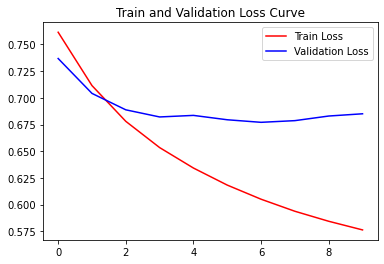

In [21]:
import matplotlib.pyplot as plt

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [22]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model\assets


# Predict

In [23]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [24]:
books_df_copy = buku.copy()
books_df_copy = books_df_copy.set_index("book_id")

In [25]:
b_id =list(rating.book_id.unique())
b_id.remove(10000)

In [26]:
import numpy as np

#Predict Recommendation by Rating
book_arr = np.array(b_id) 
user = np.array([100 for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

array([[3.8926544],
       [3.5095427],
       [3.6882756],
       ...,
       [3.4511144],
       [3.113919 ],
       [3.331861 ]], dtype=float32)

In [27]:
#reshape 
pred = pred.reshape(-1) 
#sort 5 highest rating and find book id
pred_ids = (-pred).argsort()[0:5]
pred_ids

array([ 479, 9122, 6297,  975, 1830], dtype=int64)

In [28]:
#find the book based on id
buku.iloc[pred_ids]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
479,480,18122,18122,1774510,42,440238153,9.780440e+12,Philip Pullman,2000.0,The Amber Spyglass,...,192315,217610,6693,4739,11883,39131,70648,91209,https://images.gr-assets.com/books/1329189152m...,https://images.gr-assets.com/books/1329189152s...
9122,9123,5697,5697,6624705,9,140003292X,9.781400e+12,"Anton Chekhov, Richard Pevear, Larissa Volokho...",1896.0,NaN,...,9424,9738,122,59,155,911,2667,5946,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
6297,6298,5936,5936,1739475,8,374529604,9.780375e+12,"Pablo Neruda, Ilan Stavans",1974.0,The Poetry of Pablo Neruda,...,14596,14698,239,94,223,1386,4373,8622,https://images.gr-assets.com/books/1417605511m...,https://images.gr-assets.com/books/1417605511s...
975,976,90072,90072,24501333,3,793551617,9.780794e+12,"Robert Kapilow, Dr. Seuss",NaN,NaN,...,90574,90691,262,803,1943,10781,20483,56681,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
1830,1831,12849385,12849385,17594837,58,446572993,9.780447e+12,David Baldacci,2012.0,The Innocent,...,46216,56819,3704,490,1439,9720,25219,19951,https://images.gr-assets.com/books/1329854216m...,https://images.gr-assets.com/books/1329854216s...


# Deployment

In [29]:
preda=pd.DataFrame(pred)
preda.to_json(r'predict0.json', orient='records')

In [30]:
fitur=[book_arr, user]
fitur_df=pd.DataFrame(fitur)
fitur_df.to_json(r'predict0.json', orient='records')